### 랜덤포레스트
- 순서: 데이터 전처리 -> (반복: 학습 -> 결과 확인 -> 파라미터 조정) -> 모델 저장
- 서버에서는 저장된 모델을 불러와서 예측만 하기
- 현재 문제: 데이터 전처리 후 라벨 true 값이 너무 적음 -> 전처리 다시하기

#### https://www.datacamp.com/community/tutorials/random-forests-classifier-python

##### 1. 라이브러리 가져오기

In [35]:
#Import scikit-learn dataset library
from sklearn import datasets
import pandas as pd
import numpy as np

##### 2. 데이터셋 로드 -> 컬럼 추출

In [36]:
#Load dataset
temp = pd.read_csv("outFile.csv",engine='python',encoding='cp949')
tmp = temp[["HE_HbA1c", "HE_chol", "age", "HE_glu", "HE_wc", "N_EN", "edu", 
            "Total_slp_wk","Total_slp_wd","BE3_32", "EC_wht_23", "HE_DMfh1",
            "HE_BMI","HE_DMfh2", "HE_DMfh3","BD2_31",
            "BS6_3", "BP1", "BD2_1", "BD1_11", "BE5_1", "EC_wht_5", "HE_DMdg"]]

##### 3. 데이터 전처리
- 모름/무응답 행 제거
- 중복 값 처리
- 컬럼 합치기
- null 처리 된 0 복원 등

In [37]:
tmp[:] = np.nan_to_num(tmp)
for index in tmp.columns:
     tmp = tmp.loc[tmp[index]!=9]
        
tmp[:] = np.nan_to_num(tmp)

tmp['HE_DMfh'] = 0
tmp.loc[tmp.HE_DMfh1 == 1, 'HE_DMfh'] = 1
tmp.loc[tmp.HE_DMfh2 == 1, 'HE_DMfh'] = 1
tmp.loc[tmp.HE_DMfh3 == 1, 'HE_DMfh'] = 1
del tmp['HE_DMfh1']
del tmp['HE_DMfh2']
del tmp['HE_DMfh3']
data = tmp.copy()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


##### 4. feature, label 지정

In [38]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

feature_cols = ["HE_HbA1c", "HE_chol", "age", "HE_glu", "HE_wc", "N_EN", "edu", 
            "Total_slp_wk","Total_slp_wd","BE3_32", "EC_wht_23",
            "HE_BMI","HE_DMfh","BD2_31",
            "BS6_3", "BP1", "BD2_1", "BD1_11", "BE5_1", "EC_wht_5"]

X=data[feature_cols]  # Features
y=data['HE_DMdg']  # Labels

##### 5. train, test data 나누기
- 70% training, 30% test

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### 6. 트리 생성
- 학습 및 정확도 
- percentage: predict_proba
- classification: predict
- 정확도 함수: https://scikit-learn.org/stable/modules/model_evaluation.html

In [40]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100)#Create a Gaussian Classifier
clf.fit(x_train,y_train) #train model
y_pred=clf.predict(x_test)

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

rfc_cv_score = cross_val_score(clf, X, y, cv=10, scoring="roc_auc")

print("=== Confusion Matrix ===") #true positive/ false negative/ false positive/ true nagative
print(confusion_matrix(y_test, y_pred)) #evaluate the accuracy of a classification
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[1941   17]
 [  53   88]]


=== Classification Report ===
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98      1958
        1.0       0.84      0.62      0.72       141

avg / total       0.96      0.97      0.96      2099



=== All AUC Scores ===
[0.97639022 0.9801246  0.96012531 0.95509893 0.97908039 0.98111571
 0.97332838 0.98531867 0.97154472 0.95484901]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9716975928868479


In [42]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

print("roc_auc: ",metrics.roc_auc_score(y_test, y_pred))
print("Accuracy: ",metrics.accuracy_score(y_test, y_pred))

roc_auc:  0.8077155731351285
Accuracy:  0.9666507860886137


##### 7. 생성된 트리 시각화 및 주요 특성 확인

In [43]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=feature_cols).sort_values(ascending=False)
feature_imp

HE_HbA1c        0.276308
HE_glu          0.193360
HE_chol         0.099352
age             0.068526
HE_wc           0.054283
HE_BMI          0.048938
N_EN            0.039712
Total_slp_wk    0.026937
Total_slp_wd    0.025971
EC_wht_23       0.023072
edu             0.019488
BP1             0.017564
BD1_11          0.016209
BD2_1           0.015468
BD2_31          0.014978
BE3_32          0.014197
HE_DMfh         0.013385
BS6_3           0.013215
BE5_1           0.009524
EC_wht_5        0.009512
dtype: float64

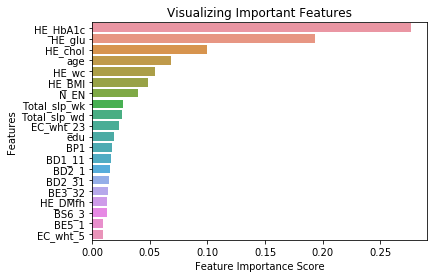

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

In [45]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

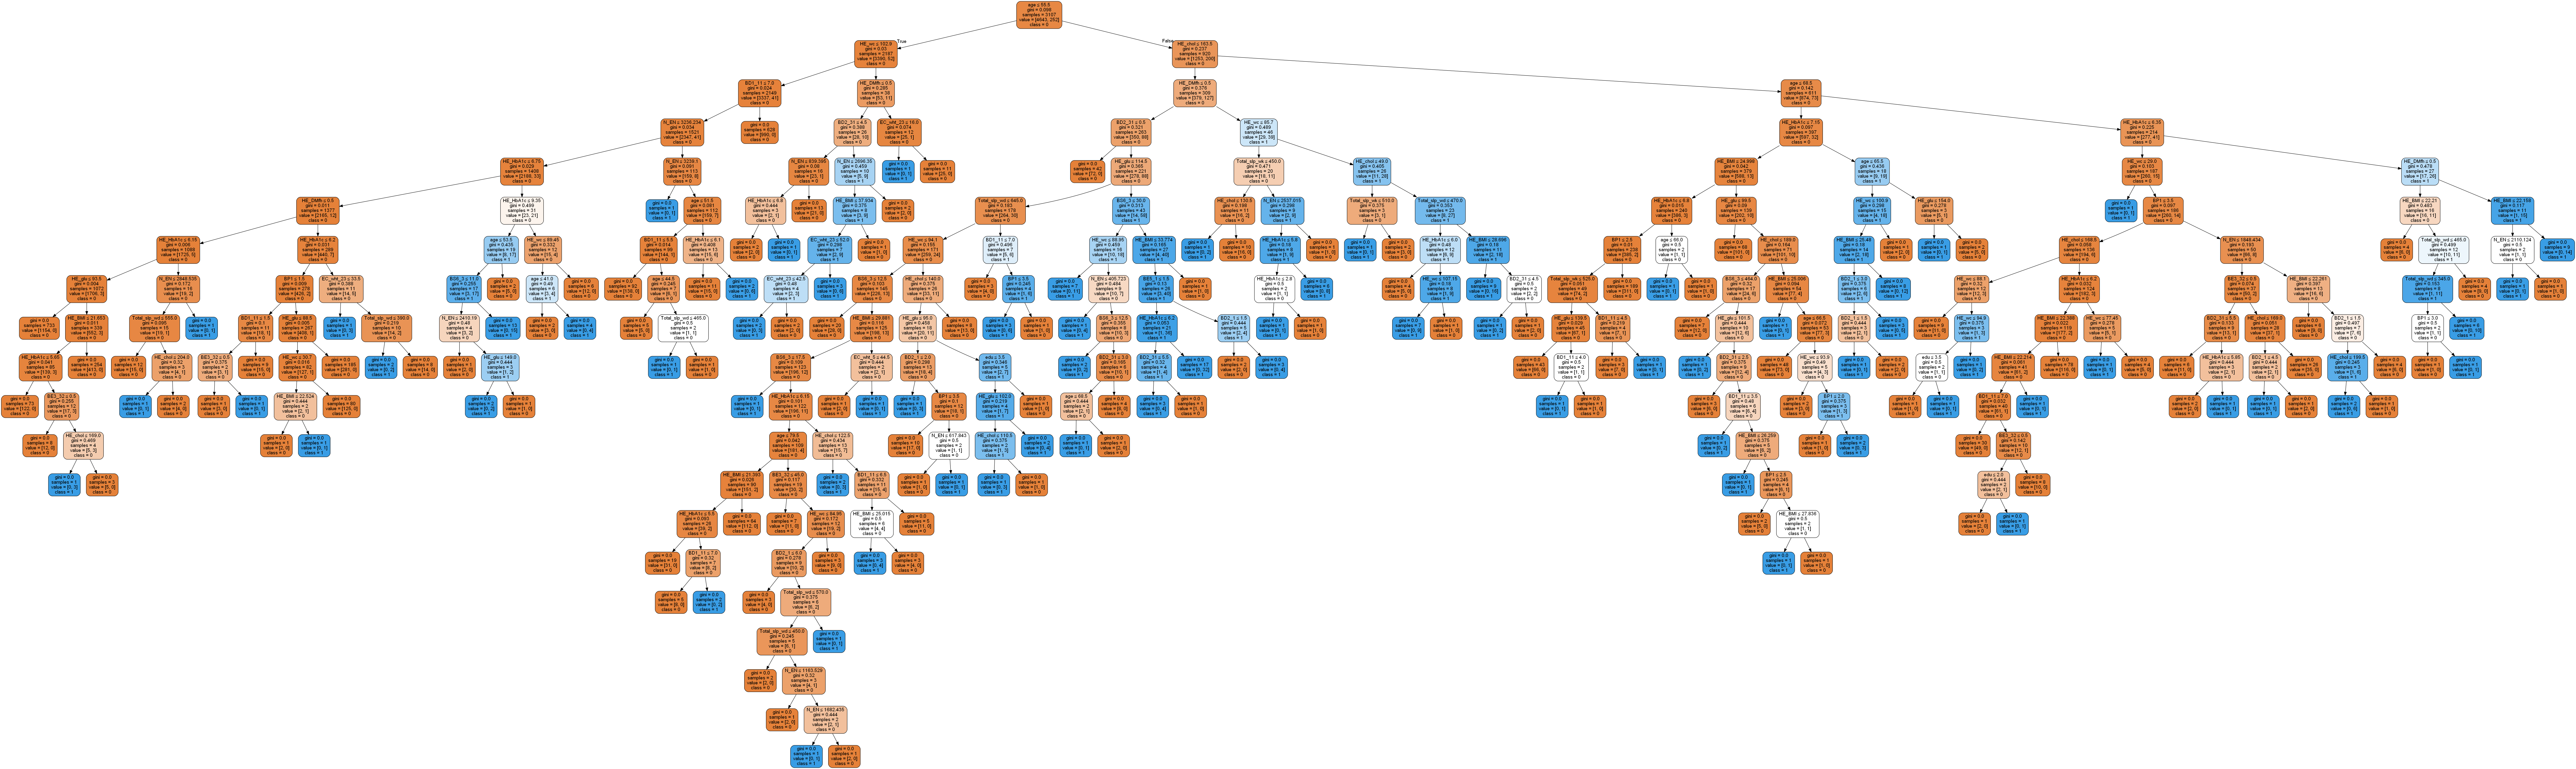

In [46]:
dot_data = StringIO()
export_graphviz(clf.estimators_[1], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('random_diabetes.png')
Image(graph.create_png())

##### 8. 파라미터 조정

In [58]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators=[20, 30, 40, 50, 60, 70]
max_features = ['auto', 'sqrt']
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth = [5, 7, 10, 15]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 7, 10, 15],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [20, 30, 40, 50, 60, 70]}


In [62]:
from sklearn.model_selection import GridSearchCV

# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 96, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, n_iter = 100, cv = 3, verbose=2)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   29.2s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=96, n_jobs=-1,
          param_distributions={'n_estimators': [20, 30, 40, 50, 60, 70], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 7, 10, 15], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [63]:
print(rf_random.best_params_)

{'n_estimators': 50, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': False}


- 추출한 파라미터 평가
- 참고: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652

In [64]:
opti_model = RandomForestClassifier(n_estimators=50, min_samples_split=10, max_features='auto', max_depth=40)
opti_model.fit(x_train,y_train) #train model
y_pred=opti_model.predict(x_test)

rfc_cv_score = cross_val_score(opti_model, X, y, cv=10, scoring="roc_auc")

print("=== Confusion Matrix ===") #true positive/ false negative/ false positive/ true nagative
print(confusion_matrix(y_test, y_pred)) #evaluate the accuracy of a classification
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[1944   14]
 [  56   85]]


=== Classification Report ===
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98      1958
        1.0       0.86      0.60      0.71       141

avg / total       0.96      0.97      0.96      2099



=== All AUC Scores ===
[0.98092103 0.98265548 0.96286857 0.94805494 0.96941701 0.98017769
 0.9624969  0.98435685 0.97299652 0.9502214 ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9694166392787181


In [65]:
print("roc_auc: ",metrics.roc_auc_score(y_test, y_pred))
print("Accuracy:",opti_model.score(x_train,y_train))
print("accuracy_score: ",metrics.accuracy_score(y_test, y_pred))

roc_auc:  0.7978433631075276
Accuracy: 0.9859039836567927
accuracy_score:  0.9666507860886137


- 그래프로 보면서 조정하기

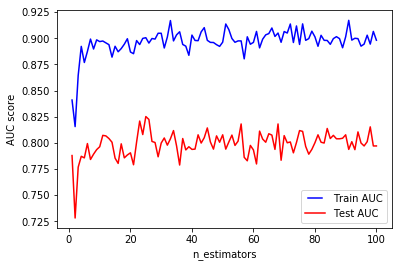

In [68]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator,  min_samples_split=10, max_features='auto', max_depth=40, n_jobs=-1)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

##### 9. 모델 저장 및 저장된 모델 불러와서 테스트하기
- ***** 서버측에서 머신러닝 사용시 모델만 불러와서 사용하면 된다.*****
- 참고: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [26]:
import pickle
# 모델 저장
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))
 
# 모델 불러오기
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)

In [27]:
result

0.9556931872320152

### AUC graph

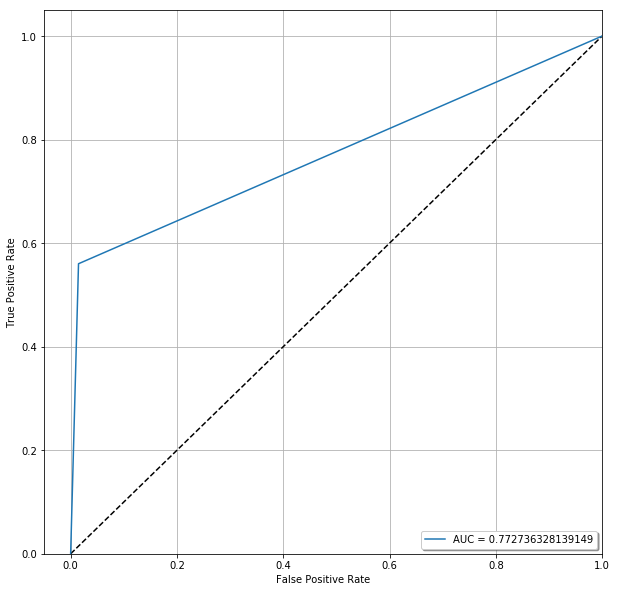

In [31]:
# overall accuracy
acc = clf.score(x_test,y_test)

# get roc/auc info
Y_score = clf.predict_proba(x_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, y_pred)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()